In [1]:
import scipy
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import pickle
import math

In [2]:
fDF = pd.read_csv('Data/featureTypes.txt', names=['featureID'])

In [3]:
print fDF.shape
print fDF['featureID'][0]
n = 10000
d = 3000

(3000, 1)
flavors raspberries cherries


In [4]:
trainDF = pd.read_csv('Data/trainData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
YDF = pd.read_csv('Data/trainLabels.txt', names = ['label'])
valXDF = pd.read_csv('Data/valData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
valYDF = pd.read_csv('Data/valLabels.txt', names = ['label'])
print trainDF.shape[0]

247847


In [5]:
W = np.random.rand(d)
B = np.zeros(n)
print W.shape

(3000,)


In [6]:
trainDF[:5]

,instanceID,featureID,value
0,1,13,0.209
1,1,83,0.209
2,1,228,0.209
3,1,242,0.209
4,1,371,0.209


In [7]:
#tDF = csr_matrix(trainDF) 
#print tDF[:5]

In [8]:
#sdf = pd.SparseDataFrame(tDF)
#print sdf[:5]

In [9]:
# Will lead to negative index if re-running
trainDF['instanceID'] -= 1
trainDF['featureID'] -= 1
sMat = csr_matrix((trainDF['value'], (trainDF['featureID'], trainDF['instanceID'])))
valXDF['instanceID'] -= 1
valXDF['featureID'] -= 1
valX = csr_matrix((valXDF['value'], (valXDF['featureID'], valXDF['instanceID'])))
Y = YDF['label'].as_matrix().transpose()
#print Y.shape
valY = valYDF['label'].as_matrix().transpose()

In [10]:
#print sMat.shape
#print sMat.todense()

In [11]:
#print sMat[:2]

In [12]:
X = sMat.copy()
print X.shape

(3000, 10000)


In [13]:
def initLamda(X, Y):
    YNorm = Y - float(Y.sum())/((float)(Y.shape[0]))
    
    return 2 * (abs(X * YNorm).max())
    
print initLamda(X, Y)

1271.869651


In [14]:
#tX = X.copy()
#print tX
#tX.data **= 2
#tA = 2*tX.sum(axis = 1)
#print max(tA), min(tA)
#print tA

In [15]:
#t = X.copy()
#print t[0]
#print t[0].sum()
#t.data **= 2
#print t[0].sum()
#print t
#TA = 2*t.sum(axis = 1)
#print TA


In [17]:
# change this to convergence condition

def rmse(input1, input2):
    out = input1 - input2
    #print out
    out **= 2
    out /= len(out)
    error = out.sum()
    return math.sqrt(error)


class Lasso:
    def __init__(self, X, Y, W, B, Lamda):
        self.X = X.copy()
        self.Y = Y.copy()
        self.W = W #.copy()  # Remove this copy later
        self.B = B #.copy()
        t = X.copy()
        t.data **= 2
        self.A = 2*t.sum(axis = 1)
        self.Lamda = Lamda
        self.delta = 0.01
        # Stores Lamda and respective RMSE
        self.trainrmse = []
        self.trainlamda = []
        self.valrmse = []
        self.vallamda = []
        self.NonZero = []
        
    def loss(self):
        return ((self.X.transpose() * self.W + self.B - self.Y) ** 2).sum() + self.Lamda * (abs(self.W)).sum()
        
    def fit(self):
        # Lamda = initLamda(self.X, self.Y)
        
        #print X.shape, W.shape
        #for epoch in range(100):
        oldLoss = self.loss()+2
        newLoss = self.loss()
        print 'Lamda: ', self.Lamda
        while oldLoss - newLoss > self.delta:
            #print sMat.transpose() * W
            # 4.1.1
            #print t1[:5], t1.shape
            #print t1.shape, B.shape, Y.shape
            XTW = (self.X.transpose() * self.W)
            R = self.Y - (self.X.transpose() * self.W) - self.B
             
            # 4.1.2
            self.B = (R + self.B) / n 
            #self.B = (self.Y - XTW) / n
            #print B.shape
            # 4.1.3
            R = (n-1) * self.B
            #R = self.Y - (XTW + self.B)
            #print R.shape
            #print R[:5]
            # R = R.reshape(-1)
            for ik in range(0, d):
                # 4.1.4
                #ik = 0
                t = (self.X[ik].transpose() * self.W[ik]).toarray().reshape(-1)
                #print t
                #print t.shape
                #print R.shape
                Ck = (2 * self.X[ik] * (R + t)).sum()
                #Ck = (2 * self.X[ik] * (self.Y - self.B - t)).sum()
                #print Ck.sum()
                # Update Weight
                WkOld = self.W[ik]
                if Ck < -self.Lamda:
                    self.W[ik] = (Ck + self.Lamda) / self.A[ik]
                elif Ck > self.Lamda:
                    self.W[ik] = (Ck - self.Lamda) / self.A[ik]
                else:
                    self.W[ik] = 0
                #print W[ik]
                # 4.1.5
                # print self.W[ik], WkOld
                #print X[ik].toarray().reshape(-1).shape, R.shape
                R = R + self.X[ik].toarray().reshape(-1) * (WkOld - self.W[ik])
                #R = self.Y - (self.X.transpose() * self.W) + self.B
            oldLoss = newLoss
            newLoss = model.loss()
            #print oldLoss, newLoss, oldLoss - newLoss
            print 'LOSS:' , newLoss
            # End of feature vector iterator
    
    def saveModel(self, filename):
        pickle.dump(self, open( filename, "wb" ))
    
    def predict(self, X):
        return (X.transpose() * self.W + self.B)
    
    def chooseCorrectLamda(self, delta = -1):
        oldLamda = self.Lamda
        if delta != -1:
            self.delta = delta
        self.fit()
        
        newRMSE = rmse(self.predict(self.X), self.Y)
        #self.TrainInfo.append([self.Lamda, newRMSE])
        self.trainrmse.append(newRMSE)
        self.trainlamda.append(self.Lamda)
        valRMSE = rmse(self.predict(valX), valY)
        self.valrmse.append(valRMSE)
        self.vallamda.append(self.Lamda)
        oldRMSE = valRMSE
        #print W
        #self.ValInfo.append([self.Lamda, valRMSE])
        self.NonZero.append((self.W != 0).sum())
        print 'Lamda: ', self.Lamda, 'RMSE: ', newRMSE, 'Val RMSE:' , valRMSE
        
        while oldRMSE >= valRMSE:
            oldLamda = self.Lamda
            self.Lamda /= 2
            self.fit()
            oldRMSE = valRMSE
            #self.TrainInfo.append([self.Lamda, newRMSE])
            newRMSE = rmse(self.predict(self.X), self.Y)
            self.trainrmse.append(newRMSE)
            self.trainlamda.append(self.Lamda)
            valRMSE = rmse(self.predict(valX), valY)
            #self.ValInfo.append([self.Lamda, valRMSE])
            self.valrmse.append(valRMSE)
            self.vallamda.append(self.Lamda)
            self.NonZero.append((self.W != 0.0).sum())
            #self.NonZero.append(self.W.toarray().count_nonzero())
            print 'Lamda: ', self.Lamda, 'RMSE: ', newRMSE, 'Val RMSE:' , valRMSE
            self.saveModel('optimal_saved_Model')
        self.Lamda = oldLamda
        self.fit()
        return oldLamda
    
def loadModel(filename):
    return pickle.load(open(filename, "rb" ))

In [18]:
model = Lasso(X, Y, W, B,initLamda(X.copy(), Y.copy()))
#model.loss()
#model.fit()

In [19]:
print model.Lamda

1271.869651


In [20]:
model.chooseCorrectLamda()

Lamda:  1271.869651
LOSS: 35562796.4047
LOSS: 19415286.7316
LOSS: 14585109.5631
LOSS: 12181653.2797
LOSS: 10809578.7318
LOSS: 10034916.0488
LOSS: 9567164.95356
LOSS: 9284260.84732
LOSS: 9074510.06155
LOSS: 8900879.82949
LOSS: 8772170.04116
LOSS: 8685380.03968
LOSS: 8626397.30085
LOSS: 8583905.60524
LOSS: 8551133.64615
LOSS: 8526166.87642
LOSS: 8507810.52965
LOSS: 8494187.60456
LOSS: 8483785.37675
LOSS: 8475649.04347
LOSS: 8469383.24277
LOSS: 8464727.40776
LOSS: 8461322.74489
LOSS: 8458836.78771
LOSS: 8456949.60368
LOSS: 8455481.28597
LOSS: 8454359.4756
LOSS: 8453515.35604
LOSS: 8452896.11482
LOSS: 8452441.14606
LOSS: 8452106.18135
LOSS: 8451857.43581
LOSS: 8451670.48857
LOSS: 8451529.04536
LOSS: 8451421.45624
LOSS: 8451339.93906
LOSS: 8451278.84029
LOSS: 8451233.5806
LOSS: 8451200.23451
LOSS: 8451175.55461
LOSS: 8451157.07467
LOSS: 8451143.08454
LOSS: 8451132.46103
LOSS: 8451124.44734
LOSS: 8451118.47555
LOSS: 8451114.07221
LOSS: 8451110.83369
LOSS: 8451108.4337
LOSS: 8451106.63063
LOS

LOSS: 2071400.14937
LOSS: 2071400.07213
LOSS: 2071399.99875
LOSS: 2071399.92891
LOSS: 2071399.86228
LOSS: 2071399.79858
LOSS: 2071399.74705
LOSS: 2071399.74181
Lamda:  79.4918531875 RMSE:  10.385356317 Val RMSE: 11.4271485176
Lamda:  39.7459265938
LOSS: 1506111.52499
LOSS: 1498014.59218
LOSS: 1496233.71161
LOSS: 1495508.00646
LOSS: 1495111.11662
LOSS: 1494861.97877
LOSS: 1494689.59594
LOSS: 1494559.87504
LOSS: 1494456.22077
LOSS: 1494371.66348
LOSS: 1494303.4897
LOSS: 1494249.44364
LOSS: 1494206.94628
LOSS: 1494173.1175
LOSS: 1494144.76171
LOSS: 1494119.6843
LOSS: 1494096.76557
LOSS: 1494075.61593
LOSS: 1494056.31911
LOSS: 1494039.05528
LOSS: 1494024.12193
LOSS: 1494011.44711
LOSS: 1494000.64294
LOSS: 1493991.3869
LOSS: 1493983.33096
LOSS: 1493976.17053
LOSS: 1493969.67846
LOSS: 1493963.71175
LOSS: 1493958.19085
LOSS: 1493953.11057
LOSS: 1493948.42302
LOSS: 1493944.11744
LOSS: 1493940.19377
LOSS: 1493936.63799
LOSS: 1493933.42651
LOSS: 1493930.53209
LOSS: 1493927.92558
LOSS: 1493925.58

LOSS: 843906.934566
LOSS: 843776.496657
LOSS: 843704.17827
LOSS: 843661.135792
LOSS: 843633.434029
LOSS: 843614.631359
LOSS: 843601.133468
LOSS: 843590.889366
LOSS: 843582.707871
LOSS: 843575.883448
LOSS: 843570.006687
LOSS: 843564.858321
LOSS: 843560.293457
LOSS: 843556.219712
LOSS: 843552.576848
LOSS: 843549.320939
LOSS: 843546.418979
LOSS: 843543.854097
LOSS: 843541.58918
LOSS: 843539.593969
LOSS: 843537.840039
LOSS: 843536.301715
LOSS: 843534.949822
LOSS: 843533.756495
LOSS: 843532.697104
LOSS: 843531.749688
LOSS: 843530.895087
LOSS: 843530.116759
LOSS: 843529.402072
LOSS: 843528.739827
LOSS: 843528.122783
LOSS: 843527.546151
LOSS: 843527.007223
LOSS: 843526.504593
LOSS: 843526.037915
LOSS: 843525.607288
LOSS: 843525.213259
LOSS: 843524.855455
LOSS: 843524.533136
LOSS: 843524.245193
LOSS: 843523.989892
LOSS: 843523.764923
LOSS: 843523.56754
LOSS: 843523.394721
LOSS: 843523.243329
LOSS: 843523.110296
LOSS: 843522.992797
LOSS: 843522.888248
LOSS: 843522.794469
LOSS: 843522.709695
LOS

9.9364816484375424

model.Lamda = 5
model.fit()

In [20]:
#model.Lamda = 1
#model.fit()

Lamda:  1
LOSS: 549572.879965
LOSS: 541753.44893
LOSS: 538986.76671
LOSS: 537664.39369
LOSS: 536916.718063
LOSS: 536447.424563
LOSS: 536130.099406
LOSS: 535906.584375
LOSS: 535742.619775
LOSS: 535618.249824
LOSS: 535521.016459
LOSS: 535442.357606
LOSS: 535377.780807
LOSS: 535323.745829
LOSS: 535277.94322
LOSS: 535238.044833
LOSS: 535202.711188
LOSS: 535171.008708
LOSS: 535142.351434
LOSS: 535116.288007
LOSS: 535092.505917
LOSS: 535071.02164
LOSS: 535051.474485
LOSS: 535033.780201
LOSS: 535017.657273
LOSS: 535002.98132
LOSS: 534989.658126
LOSS: 534977.493847
LOSS: 534966.385151
LOSS: 534956.251161
LOSS: 534946.999618
LOSS: 534938.549148
LOSS: 534930.824042
LOSS: 534923.751515
LOSS: 534917.263229
LOSS: 534911.295398
LOSS: 534905.790668
LOSS: 534900.705515
LOSS: 534895.99278
LOSS: 534891.607787
LOSS: 534887.518012
LOSS: 534883.704416
LOSS: 534880.134029
LOSS: 534876.780452
LOSS: 534873.622013
LOSS: 534870.640477
LOSS: 534867.82026
LOSS: 534865.148006
LOSS: 534862.612168
LOSS: 534860.20255

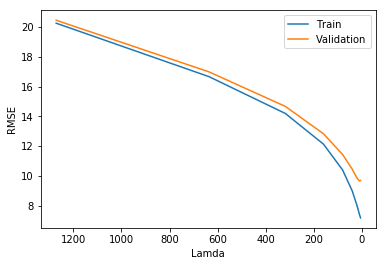

In [21]:
import matplotlib.pyplot as plt
plt.plot(model.trainlamda, model.trainrmse)
plt.plot(model.vallamda, model.valrmse)
plt.ylabel('RMSE')
plt.xlabel('Lamda')
ax = plt.gca()
ax.invert_xaxis()
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
#plt.savefig('RMSEvsLamda.png')

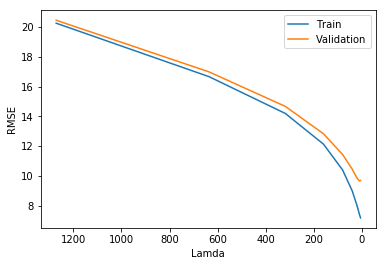

In [23]:
import matplotlib.pyplot as plt
plt.plot(model.trainlamda, model.trainrmse)
plt.plot(model.vallamda, model.valrmse)
plt.ylabel('RMSE')
plt.xlabel('Lamda')
ax = plt.gca()
ax.invert_xaxis()
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
#plt.savefig('RMSEvsLamda.png')

[134, 223, 328, 503, 802, 1179, 1668, 2134, 2494]


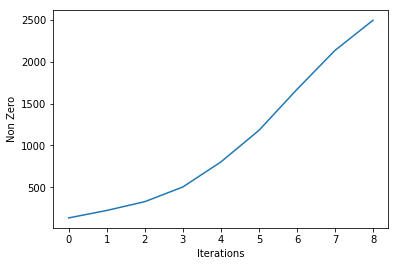

In [22]:
print model.NonZero
import matplotlib.pyplot as plt
plt.plot(model.NonZero)
plt.ylabel('Non Zero')
plt.xlabel('Iterations')
#plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
#plt.savefig('NonZeroElements.png')

In [41]:
model.saveModel('savedModel')

In [33]:
print rmse(model.predict(valX), valY)
print rmse(X.transpose() * model.W, valY)
print model.predict(valX)
print valY

9.91716403142
8.72776459914
[ 105.99568471   89.91152782   89.58389762 ...,   85.22661544   87.12956694
   86.28108135]
[92 90 86 ..., 92 89 88]


In [28]:
testXDF = pd.read_csv('Data/testData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
testX = csr_matrix((valXDF['value'], (valXDF['featureID'], valXDF['instanceID'])))
testPredicted = model.predict(testX)
print testPredicted
np.savetxt("out.csv", testPredicted, delimiter=",")
#testPredicted.to_csv('out.csv')

[ 105.71206656   85.54415933   87.60385796 ...,   87.82942353   87.01643808
   85.78716094]


In [22]:
modelOne = loadModel('./lessOne/savedModelGraph')
print rmse(model.predict(valX), valY)

EOFError: 

In [48]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=896)
clf.fit(X.transpose(), Y)

Lasso(alpha=896, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [49]:
out = clf.predict(X.transpose())

In [50]:
rmse(out, Y)

3.396173963447691

In [51]:
out = clf.predict(valX.transpose())

In [52]:
rmse(out, valY)

3.3895861945081145

In [33]:
Big = (X + valX) / 2

(3000, 10000)


In [ ]:
print 5